### Lab 6: Empirical comparison of classifiers over WTDT dataset 

Initial imports and function to load/save the dataset

In [ ]:
#Import packages

import numpy as np
from numpy.typing import NDArray
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Auxiliary functions

def onehot2cat(y:NDArray) -> NDArray:
    '''Convert y in one_hot to categorical'''
    return np.argmax(y, axis=1) 


def loadDataset(fn:str, toCat:bool=False) -> NDArray:
    '''load dataset'''
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        
    X = data['X'] 
    if toCat: y = onehot2cat(data['Y'])
    else:     y = data['Y'] 
    
    return X, y


def saveSKLModel(fn:str, model) -> None:
    '''save SKLearn model as pickle'''
    with open(fn, 'wb') as f:
        pickle.dump(model, f)
        
#load dataset

fnt = 'wtdt-part.pickle'
X, y = loadDataset(fnt, toCat=True)
print(X.shape)
print(y.shape)


(14000, 787)
(14000,)


# Random Forest

I started by analyzing the dataset to make an educated guess on what the best classifier might be.

The dataset has 140000 samples and 787 features divided equally among 7 fault classes, each with 2000 samples. Reading the introduction for the assignment It seems it represents fault classification data collected from multiple experimental repetitions rather than sequential, time-dependent recordings, which was my initial guess.

The 7 labels are one_hot encoded, which means that the dataset is organized like:

|X_0|X_1|X_2|...|X_786|y_0|y_1|y_2|y_3|y_4|y_5|y_6|

However, scikit-learn classifiers expect the labels in Categorical format, so the Y has to be converted, ending up in the following shape:

|X_0|X_1|X_2|...|X_786|y|

From the information given I made the following conclusions:
* **High Dimensionality**: 787 features per sample, there may be a way to improve performance if not all features are usefult
* **Multi-class Classification**: There are 7 fault classes, the dataset guesses which one the specific sample represents, by outputting a 0-6 value
* **Large Sample Size**: 14,000 samples in total, with balanced distribution across classes.
* **Non-Time Series Nature**: No temporal dependency from sample to sample

Given the dataset's size, dimensionality, and multi-class nature, **Random Forest** is likely the best starting point due to its balance of performance, robustness to overfitting, and ability to handle high-dimensional features.

I will start with a benchmark to see how good it really is:

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into a training set and a test set, decided to keep random_state=42 to have reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9996428571428572


The accuracy is 100%, this was a suspicious result right away, if this is true, there is no competition, I will save the dataSet and test it in the server

In [8]:
saveSKLModel("T1-randomForest.pickle", model)

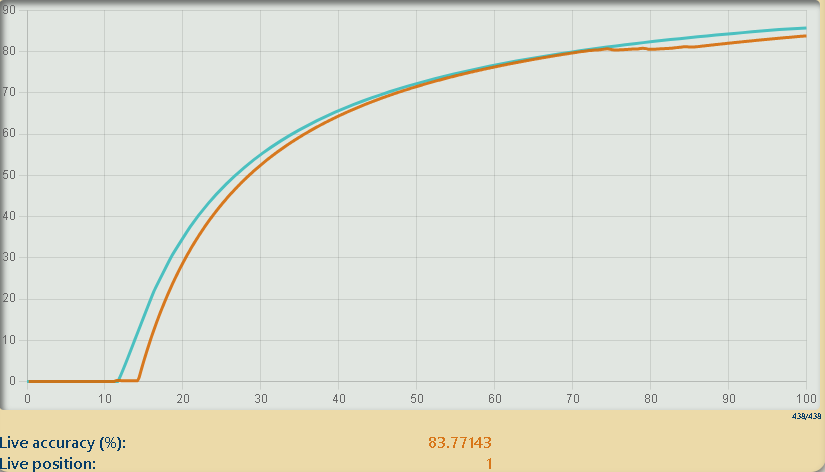

(In orange):
In the server, the accuracy is 83.77143%. This is not a bad result but there are some inconsistencies, there is a 16% difference in performance from my local test to the server test. Additionaly, analyzing the data I can see that the beggining 14% had an accuracy of almost 0%. The accuracy was also lower in the ending 28%.

At this time I though that the test dataset present in the server had been modified, by adding some noise to fault class 0, to make the challenge harder. Since the accuracy is really very low I made a small test to verify if this initial class was indeedn generalizable.

I trained the exact same mode, but this time only on the first 2000 samples, in order to maximize performance on that same class:

In [6]:
start_index = 0
end_index = 2000
X_train_0 = X[start_index:end_index]
y_train_0 = y[start_index:end_index]

# I add here also the random_state=42 to have reproducible results
model = RandomForestClassifier(random_state=42)
model.fit(X_train_0, y_train_0)
saveSKLModel("T1-randomForest.pickle", model)

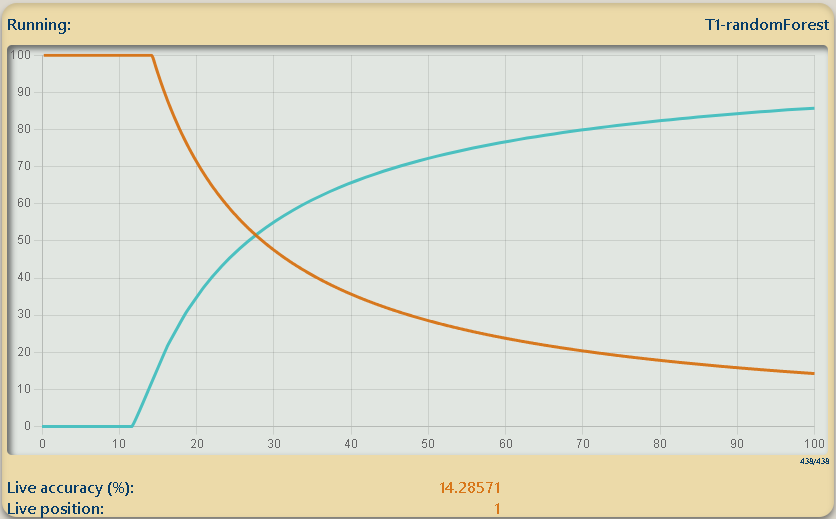

Clearly the class_0 is reproducible, but it seems like the model is unable to learn the first class when trained on the entire dataset. There is no class imbalance. The model may be overfitting, but in my local test I have very good performance (100%). Once again I though the initial class had been perturbed significantly, in order to make a harder competition.

So now I have 2 problems:

* I have no way to locally test, whether a model that I train is actually a better model (half of them have 100% accuracy)
* I have to find a way to create a model that generalizes well on every single class

Solution:
* I have to find a better way to measure performance

Possible solution: **Cross-Validation**

* In k-fold cross-validation, the dataset is split into k subsets (or folds).
* The model is trained on k-1 folds and tested on the remaining fold.
* This process is repeated k times, with each fold serving as the test set once.
* The final performance metric is the average of the results across all k folds.

In [ ]:
from sklearn.model_selection import cross_val_score


model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X, y, cv=5)